In [24]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes = os.listdir(self.root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.paths.append(os.path.join(class_dir, filename))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and their respective class folders.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Create a list of file paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        
        class_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        # Assign an integer label to each class/folder
        self.class_to_int = {c: idx for idx, c in enumerate(class_folders)}
        
        for class_folder in class_folders:
            folder_path = os.path.join(root_dir, class_folder)
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(folder_path, file))
                    self.labels.append(self.class_to_int[class_folder])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Convert grayscale images to RGB
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = CustomImageDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/train', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a sample from the dataset
image, label = dataset[0]
print(image.shape, label)

torch.Size([3, 64, 64]) 0


In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F

In [27]:
# from torch.utils.data import DataLoader
# train_transforms = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()  
# ])

# dataset = CustomDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj/', transform = train_transforms)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [28]:
# test_dataset = datasets.ImageFolder(os.path.dirname('C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/test-no-labels/'), transform = train_transforms)


# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [30]:
class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=12):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=1, padding=2)
        # self.conv2 = nn.Conv2d(in_channels=254, out_channels=128, kernel_size=5, stride=1, padding=2)
        # self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, stride=1, padding=2)
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(131072, 512)  
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x))
        x1 = self.pool(x1)
        # x2 = F.leaky_relu(self.conv2(x1))
        # x2 = self.pool(x2)
        # x3 = F.leaky_relu(self.conv3(x2))
        # x3 = self.pool(x3)
        x5 = x1.view(x1.size(0), -1) 
        x5 = self.dropout(x5)
        x6 = F.leaky_relu(self.fc1(x5))
        x6 = self.dropout(x6)
        out = self.fc2(x6)
        return out

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN_x().to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

num_epochs = 40

train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:  
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        torch.cuda.empty_cache()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')

    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):  # Using test_loader as validation_loader
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(test_loader)
    val_loss_values.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

# Plot the training and validation loss values
plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

print("Training complete.")

Epoch [1/40], Step [0/378], Loss: 2.5072


KeyboardInterrupt: 

Epoch [1/5], Step [0/378], Loss: 2.4963
Epoch [1/5], Step [100/378], Loss: 2.0622
Epoch [1/5], Step [200/378], Loss: 1.3968
Epoch [1/5], Step [300/378], Loss: 0.8732
Epoch [1/5], Average Training Loss: 1.5509
Epoch [1/5], Average Validation Loss: 0.9115
Epoch [2/5], Step [0/378], Loss: 1.1497
Epoch [2/5], Step [100/378], Loss: 0.6240
Epoch [2/5], Step [200/378], Loss: 0.6600
Epoch [2/5], Step [300/378], Loss: 0.5141
Epoch [2/5], Average Training Loss: 0.7152
Epoch [2/5], Average Validation Loss: 0.5979
Epoch [3/5], Step [0/378], Loss: 0.8530
Epoch [3/5], Step [100/378], Loss: 0.4198
Epoch [3/5], Step [200/378], Loss: 0.4049
Epoch [3/5], Step [300/378], Loss: 0.4373
Epoch [3/5], Average Training Loss: 0.4835
Epoch [3/5], Average Validation Loss: 0.4023
Epoch [4/5], Step [0/378], Loss: 0.4877
Epoch [4/5], Step [100/378], Loss: 0.8108
Epoch [4/5], Step [200/378], Loss: 0.2595
Epoch [4/5], Step [300/378], Loss: 0.3152
Epoch [4/5], Average Training Loss: 0.3856
Epoch [4/5], Average Validati

ValueError: too many values to unpack (expected 3)

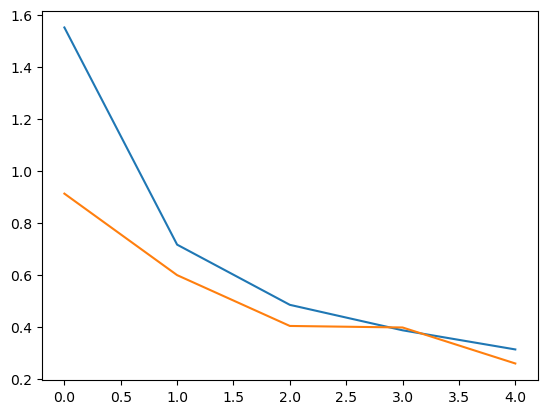

In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()  
num_epochs = 5
accumulated_test_accuracies = []
num_classes = 12  # Assuming you have 10 classes, modify as needed

for run in range(3):  # Repeat the entire loop 3 times
    model = SimpleCNN_x().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

            torch.cuda.empty_cache()
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')

        # Validation Phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(test_loader):  # Using test_loader as validation_loader
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(test_loader)
        val_loss_values.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

    # Plot the training and validation loss values
    plt.plot(train_loss_values, label=f"Training Loss - Run {run+1}")
    plt.plot(val_loss_values, label=f"Validation Loss - Run {run+1}")

    print("Training complete.")
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computations (not needed in evaluation and saves memory)
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Determine prediction accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    accumulated_test_accuracies.append(test_accuracy)

    print(f"Run {run+1} Test Accuracy: {test_accuracy:.2f}%")


# After the 3 runs, compute the average accuracy
average_accuracy = sum(accumulated_test_accuracies) / 3

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()
print(f"Average Test Accuracy over 3 runs: {average_accuracy:.2f}%")


In [ ]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

# Disable gradient computations (not needed in evaluation and saves memory)
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Determine prediction accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.71%


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()  
])
test_dataset = datasets.ImageFolder(os.path.dirname('C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/test-no-labels/'), transform = train_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt

c_names = ['1','2','12','13','14','15','17','23','25','26','28','33']

def test_images(model, device, image_tensors, class_names):

    assert image_tensors.size(0) == 10
    
    
    model.eval()
    image_tensors = image_tensors.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensors)
        _, predicted_indices = outputs.max(1)  

    plt.figure(figsize=(20, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        predicted_class = class_names[predicted_indices[i].item()]
        
    
        np_image = image_tensors[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(np_image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')  

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
def display_predictions(dataset, model, num_images=25, num_columns=5):
   
    num_rows = int(num_images / num_columns) + (num_images % num_columns > 0)
    
    plt.figure(figsize=(15, 5*num_rows))
    for i in range(num_images):
        image, true_label = dataset[i]
        
    
        input_tensor = image.unsqueeze(0).to(device)
       
    
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted_label = torch.max(outputs[2], 1)
        
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        plt.subplot(num_rows, num_columns, i+1)
        plt.imshow(image)
        plt.title(f"True: {dataset.classes[true_label]}\nPredicted: {dataset.classes[predicted_label.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_dataset, model, num_images=12*5)

IndexError: index 2 is out of bounds for dimension 0 with size 1

<Figure size 1500x6000 with 0 Axes>